<a href="https://colab.research.google.com/github/cdiegor/Metaheuristicas/blob/main/PEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema de Escalonamento de Veículos

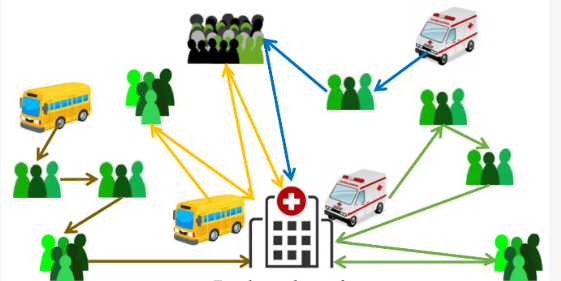

## Introdução

O problema de escalonamento de veículos (VSP) está relacionado com o agendamento de um número de veículos que devem visitar um número de locais para pegar ou entregar mercadorias ou realizar algum serviço. Os termos "veículo" e
"local" foram usados para fornecer uma cenário, mas muitas aplicações do modelo PEV têm nada a ver com veículos reais visitando locais. O problema é algumas vezes referido na literatura como o problema do despacho do caminhão, roteirização do transporte, roteamento de veículos, ou o problema de entrega.

Fonte: C.D.T. WATSON-GANDY, **THE VEHICLE SCHEDULING PROBLEM: A SURVEY**. Operations Research Society of New Zealand, 1981.

### Definição do problema

Vamos considerar que temos como entrada um grafo $G = (V, A)$ completo no qual um nó específico é chamado de depósito. Os demais nós do grafo são os clientes. Para qualquer arco $(u,v) \in A$, vamos considerar conhecida uma métrica $t(u,v)$ o tempo de deslocamento entre os nós $u$ e $v$.

Além disso temos um conjunto de tarefas $J$, cada uma delas com uma data de início $d_j$ e uma duração de execução $p_j$. Estas tarefas possuem também uma sequência de nós $S_j$ que devem ser visitados para cumprir a tarefa.

Com uma frota limitada em $R$ veículos, queremos determinar qual é o conjunto de rotas a serem repartidas entre eles de forma a atender todas as tarefas com um atraso total mínimo.

Por simplicidade, vamos reproduzir o que foi realizado no problema do caixeiro viajante e considerar que cada vértice do grafo é um ponto num espaço euclidiano $\mathbb{R}^2$ e que a métrica de tempo é a própria distância euclidiana.

In [1]:
import matplotlib.pyplot as plt
import math
import random
import time
import itertools
import urllib
import csv

In [2]:
def distancia(x,y):
  return math.dist(x,y)/1000

In [3]:
class Tarefa:
  def __init__(self):
    self.index: int = 0
    self.data: float = 0
    self.duracao: float = 0
    self.seq:list[tuple[int, int]] = []

  def duracao_total(self):
    return self.duracao + tamanho_rota(self.seq)

  def __str__(self):
    return f"Data = {self.data}\tDuracao = {self.duracao_total()}\t Rota = {self.seq}"
  def __repr__(self):
    return f"{self.index}"

class PEV:
  def __init__(self):
    self.clientes:list[tuple[int, int]] = []
    self.tarefas:list[Tarefa] = []
    self.veiculos:int = 0
    self.rotas: list[list[Tarefa]] = []
    self.atraso: float

  def atraso_rota(self, r: int):
    atraso = 0.
    t = 0.
    local = self.clientes[0]
    for i in range(len(self.rotas[r])):
      t += distancia(local, self.rotas[r][i].seq[0])
      atraso += max(t - self.rotas[r][i].data, 0)
      t += self.rotas[r][i].duracao_total()
      local = self.rotas[r][i].seq[-1]
    return atraso

  def atraso_total(self):
    return sum(self.atraso_rota(r) for r in range(self.veiculos))

  def __repr__(self):
    return f"Clientes = {len(self.clientes)-1}\tVeiculos = {self.veiculos}\tCusto = {self.atraso_total()}"
  def __str__(self):
    return f"Clientes = {len(self.clientes)-1}\tVeiculos = {self.veiculos}\tCusto = {self.atraso_total()}"

In [4]:
def tamanho_rota(rota):
  "A distância total percorrida entre dois pares consecutivos em uma rota"
  return sum(distancia(rota[i-1], rota[i]) for i in range(len(rota)))

### Construindo instâncias fictícias

In [5]:
import copy

def gerar_pev (n: int, r: int, t: int, largura=1000, altura=1000, rseed=233):
  """Cria uma instância do PEV com n clientes, r veículos e t tarefas
  com coordenadas aleatórias no máximo (largura x alutura)"""
  pev = PEV()
  random.seed(rseed)
  pev.veiculos = r

  pev.clientes = [ (largura//2 + (2*random.randrange(2)-1)*(100+random.randrange(largura//2-100)),
                    altura//2 + (2*random.randrange(2)-1)*(100+random.randrange(altura//2-100)))
                    for c in range(n+1) ]
  pev.clientes[0] = (largura//2, altura//2)

  intervalos = t//r

  for j in range(t):
    tar = Tarefa()
    tar.index = j
    tar.data = random.randrange(intervalos)*0.5 + random.random()
    tar.duracao = random.random()
    pev.tarefas.append(tar)

  faltantes = copy.deepcopy(pev.clientes[1:])
  while(faltantes):
    if (t < len(faltantes)):
      clientes_sorteados = random.sample(faltantes, t)
      for j in range(t):
        pev.tarefas[j].seq.append(clientes_sorteados[j])
      for x in clientes_sorteados: faltantes.remove(x)
    else:
      for c in faltantes:
        j = random.randrange(t)
        pev.tarefas[j].seq.append(c)
      break

  for x in range(r): pev.rotas.append([])

  return pev


In [6]:
gerar_pev(30, 4, 40)

Clientes = 30	Veiculos = 4	Custo = 0.0

### Desenhando a solução

In [7]:
def plot_rota(deposito, rota, cor):
  x = []
  y = []
  text = []
  style = []

  x.append(deposito[0])
  y.append(deposito[1])
  text.append('')
  style.append('dashed')
  for i in range(len(rota)):
    for j in range(len(rota[i].seq)):
      x.append(rota[i].seq[j][0])
      y.append(rota[i].seq[j][1])
      text.append(rota[i].index)
      if (j < len(rota[i].seq)-1):
        style.append('solid')
      else:
        style.append('dashed')

  for i in range(len(x)):
    plt.plot([x[i-1], x[i]], [y[i-1], y[i]], color=cor, linewidth=2, linestyle=style[i-1])

  plt.scatter(x, y, color=cor, linewidth=10)

  for i in range(len(x)):
    plt.annotate(text[i], (x[i]-10, y[i]-10 ))


In [8]:
import seaborn as sns;
def plot_pev(pev):

  print(pev)

  palette = itertools.cycle(sns.color_palette("colorblind", pev.veiculos))
  for rota in pev.rotas:
    plot_rota(pev.clientes[0], rota, next(palette))

  plt.plot(pev.clientes[0][0], pev.clientes[0][1],
           marker="D", markersize=10, markeredgecolor="black", markerfacecolor="grey")
  plt.axis("scaled")

  plt.show()


Data = 1.9788547276653543	Duracao = 0.504073277905837	 Rota = [(111, 631)]
Data = 0.3296922178940317	Duracao = 2.3903683411032004	 Rota = [(143, 977), (90, 17)]
Data = 1.7463106164255238	Duracao = 0.9670342846960015	 Rota = [(967, 44)]
Data = 0.6338328843874979	Duracao = 0.722410487409172	 Rota = [(45, 361)]
Data = 1.5070638031291734	Duracao = 2.257879481416753	 Rota = [(779, 909), (358, 263), (753, 89)]
Data = 1.094177735845785	Duracao = 0.03705484551588656	 Rota = [(295, 872)]
Data = 1.574161610203404	Duracao = 2.39267008764451	 Rota = [(162, 41), (806, 363), (783, 665), (195, 302)]
Data = 1.2605410872820575	Duracao = 2.0289556706941294	 Rota = [(983, 667), (372, 1)]
Data = 0.28463224255523545	Duracao = 1.3665797822074393	 Rota = [(659, 764), (291, 219)]
Data = 1.785028490210276	Duracao = 2.984827649167784	 Rota = [(356, 848), (88, 759), (810, 195)]
Clientes = 20	Veiculos = 3	Custo = 28.51535554670802


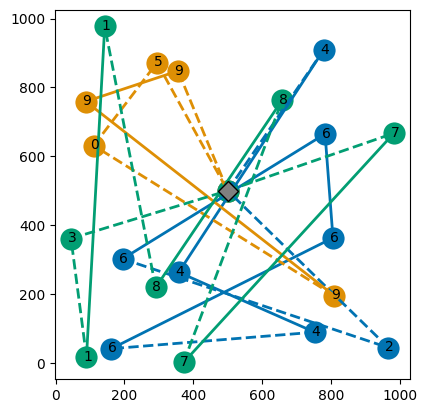

In [9]:
nc = 20
nv = 3
nt = 10

pev = gerar_pev(nc, nv, nt)

for x in pev.tarefas:
  print(x)

taf = copy.deepcopy(pev.tarefas)
random.shuffle(taf)
for i in range(nv):
  pev.rotas[i] = taf[i*nt//nv:(i+1)*nt//nv]

plot_pev(pev)



In [10]:
for rota in pev.rotas:
  print(rota)

[4, 6, 2]
[9, 0, 5]
[7, 8, 1, 3]


## Algoritmo Genético para o PEV

### População inicial

In [11]:
def populacao_inicial(pev: PEV, tamanho_populacao: int):
  Populacao:PEV = []
  for i in range(tamanho_populacao):
    x = copy.deepcopy(pev)
    random.shuffle(x.tarefas)
    for r in range(x.veiculos):
      x.rotas[r] = x.tarefas[r*len(x.tarefas)//x.veiculos:(r+1)*len(x.tarefas)//x.veiculos]
    Populacao.append(x)
  return Populacao

### Operadores de cruzamento



In [12]:
import copy

def encontrar(vetor, elemento):
  index:int = 0
  while (index < len(vetor)):
    if vetor[index].index == elemento.index:
      return index
    index = index + 1
  return -1


def cruzamento_aresta_alternada(mae1, mae2):
  filha = []
  restante = copy.deepcopy(mae1)
  n = len(mae1)

  # Selecionar um ponto inicial
  atual = mae1[random.randrange(n)]
  rindex = encontrar(restante, atual)
  iter = 0
  del restante[rindex]
  filha.append(atual)

  # Cruzamento de aresta alternata
  while len(restante) > 0:
    # print("       it=", iter)
    # Encontrar o indice da tarefa atual na mae
    if iter % 2 == 0: indice = encontrar(mae1, atual)
    else:             indice = encontrar(mae2, atual)

    # Encontrar o elemento seguinte
    naoEncontrado = True
    while naoEncontrado:
      indice = (indice + 1)%n
      naoEncontrado = False
      if iter % 2 == 0: rindex = encontrar(restante, mae1[indice])
      else:             rindex = encontrar(restante, mae2[indice])

      if rindex < 0:
        naoEncontrado = True
      #print("         procurando=", indice)
    if iter % 2 == 0: atual = mae1[indice]
    else:             atual = mae2[indice]

    del restante[rindex]
    filha.append(atual)
    iter = iter + 1

  return filha

### Operadores de mutação

In [13]:
def localizar(S: PEV, i: int, j: int):
  ri: int = -1 # Rota da tarefa i
  li: int = -1 # Local da tarefa i na rota
  rj: int = -1 # Rota da tarefa j
  lj: int = -1 # Local da tarefa j na rota

  for k, rota in enumerate(S.rotas):
    for l, tarefa in enumerate(rota):
      if tarefa.index == S.tarefas[i].index:
        ri = k
        li = l
      if tarefa.index == S.tarefas[j].index:
        rj = k
        lj = l
  return ri, li, rj, lj

def trocar(S:PEV, i:int, j: int):
  ri, li, rj, lj = localizar(S, i, j)
  S.rotas[ri][li] = S.tarefas[j]
  S.rotas[rj][lj] = S.tarefas[i]

def mover(S:PEV, i:int, j: int):
  ri, li, rj, lj = localizar(S, i, j)
  del S.rotas[rj][lj]
  if ri == rj and lj < li:
    S.rotas[ri].insert(li, S.tarefas[j])
  else:
    S.rotas[ri].insert(li+1, S.tarefas[j])

def reverter(S:PEV, i:int, j: int):
  ri, li, rj, lj = localizar(S, i, j)
  if ri == rj:
    if (li < lj):
      S.rotas[ri][li:lj] = reversed(S.rotas[ri][li:lj])
    else:
      S.rotas[rj][lj:li] = reversed(S.rotas[rj][lj:li])

### Algoritmo Genético

In [14]:
def avaliar_populacao(populacao: list[PEV], elite):
  for x in populacao : x.atraso = x.atraso_total()
  populacao.sort(key=lambda x : x.atraso)

In [15]:
def torneio(populacao: list[PEV], elite: float, vies: float, rodadas: int):
  v = random.uniform(0, 1)
  iter = 1
  while (iter <= rodadas):
    if (v < vies):
      candidato = random.randrange(round(len(populacao)*elite))
    else:
      candidato = random.randrange(len(populacao))
    if (iter == 1):
      melhor = candidato
    elif (populacao[candidato].atraso < populacao[melhor].atraso):
      melhor = candidato
    iter = iter + 1
  return melhor

def selecao(populacao: list[PEV], elite: float, vies: float, rodadas: int):
  x = torneio(populacao, elite, vies, rodadas)
  y = torneio(populacao, elite, vies, rodadas)
  return x, y

In [16]:
def checar_rotas(x: PEV):
  check = [0] * len(x.tarefas)
  for r in x.rotas:
    for t in r:
      check[t.index] = 1
  return sum(check) == len(x.tarefas)

In [17]:
def mutacao(x: PEV):
  v = random.uniform(0, 1)
  i = random.randrange(len(x.tarefas))
  j = random.randrange(len(x.tarefas))
  if (v < 1/3):
    #print("    trocar")
    trocar(x, i, j)
  elif (v < 2/3):
    #print("    mover")
    mover(x, i, j)
  else:
    #print("    reverter")
    reverter(x, i, j)
  #if checar_rotas(x) == False:
    #print("Erro na mutacao")

In [18]:
def cruzamento(x: PEV, y: PEV):

  px = []
  for r in x.rotas: px.extend(r)
  py = []
  for r in y.rotas: py.extend(r)

  #print(px)
  #print(py)

  #print("    aresta alternada")
  pa = cruzamento_aresta_alternada(px, py)
  #print("    aresta alternada")
  pb = cruzamento_aresta_alternada(py, px)

  #print("    reconversao")
  a = copy.deepcopy(x)
  a.rotas = []
  inicio = 0
  for r in x.rotas:
    fim = inicio + len(r)
    a.rotas.append(pa[inicio:fim])
    inicio = fim

  #print("    reconversao")
  b = copy.deepcopy(y)
  b.rotas = []
  inicio = 0
  for r in y.rotas:
    fim = inicio + len(r)
    b.rotas.append(pb[inicio:fim])
    inicio = fim

  if checar_rotas(a) == False or checar_rotas(b) == False:
    print("Erro no cruzamento")

  return a, b

In [19]:
def checar_pop(pop):
  for j in range(len(pop)):
    x = pop[j]
    if (len(x.rotas) < x.veiculos):
      print("Menos rotas que veiculos no individuo ", j)
    for r in range(len(x.rotas)):
      if (len(x.rotas[r]) == 0):
        print("Rota ", r, " vazia no individuo", j)

def genetico(pev: PEV, tamanho_populacao: int, elite: float,
             vies: float, taxa_mutacao: float, rodadas: int, max_iter:int):
  proxima = populacao_inicial(pev, tamanho_populacao)
  avaliar_populacao(proxima, elite)
  iter = 0
  tamanho_elite = round(tamanho_populacao*elite)
  tamanho_mutacao = round(tamanho_populacao*taxa_mutacao)

  #for x in proxima: print(x)

  while (iter < max_iter):
    atual = copy.deepcopy(proxima)

    #checar_pop(atual)

    #Próxima geração mantém a elite atual
    proxima[:tamanho_elite] = copy.deepcopy(atual[:tamanho_elite])

    # Elementos mutantes da próxima população
    for j in range(tamanho_elite,tamanho_elite+tamanho_mutacao):
      mutant_index = torneio(atual, elite, vies, rodadas)
      proxima[j] = copy.deepcopy(atual[mutant_index])
      #print("  mutacao")
      mutacao(proxima[j])

    # Elementos cruzados da próxima população
    j = tamanho_elite+tamanho_mutacao
    while (j < tamanho_populacao):
      #print("  selecao")
      x, y = selecao(atual, elite, vies, rodadas)
      #print("  cruzamento")
      z, w = cruzamento(atual[x], atual[y])
      proxima[j] = z
      j = j + 1
      if (j < tamanho_populacao):
        proxima[j] = w
        j = j + 1
    #print("  avaliacao")
    avaliar_populacao(proxima, elite)
    iter = iter + 1
    print("(", iter, "): Melhor solucao = ", proxima[0].atraso)
  return proxima[0]

### Averiguando parâmetros

( 1 ): Melhor solucao =  173.7710644328164
( 2 ): Melhor solucao =  172.00538560715398
( 3 ): Melhor solucao =  168.01643447027578
( 4 ): Melhor solucao =  168.01643447027578
( 5 ): Melhor solucao =  165.15946686257675
( 6 ): Melhor solucao =  161.95403486698297
( 7 ): Melhor solucao =  161.95403486698297
( 8 ): Melhor solucao =  160.53980476562884
( 9 ): Melhor solucao =  160.53980476562884
( 10 ): Melhor solucao =  156.65786615913032
( 11 ): Melhor solucao =  156.65786615913032
( 12 ): Melhor solucao =  156.65786615913032
( 13 ): Melhor solucao =  156.63744711798876
( 14 ): Melhor solucao =  156.63744711798876
( 15 ): Melhor solucao =  151.33602437824314
( 16 ): Melhor solucao =  150.95424354233214
( 17 ): Melhor solucao =  150.26069617924128
( 18 ): Melhor solucao =  149.98890589699948
( 19 ): Melhor solucao =  149.98890589699948
( 20 ): Melhor solucao =  147.47773074186748
( 21 ): Melhor solucao =  147.47773074186748
( 22 ): Melhor solucao =  146.18273887927984
( 23 ): Melhor soluc

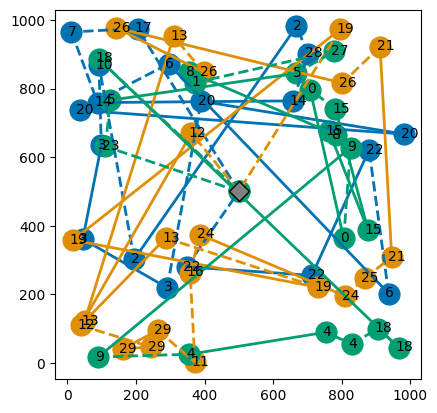

In [22]:
pontos = 60
veiculos = 3
tarefas = 30

exemplo = gerar_pev(pontos, veiculos, tarefas)

solucao = genetico(exemplo,
                   tamanho_populacao=50, elite=0.2, vies=0.5,
                   taxa_mutacao=0.3, rodadas=3, max_iter=200)

plot_pev(solucao)


## Exercícios



1.   Execute o algoritmo genético, incrementando o número de máximo de iterações max_iter = {50, 100, 200, 1000}. Como pode ser descrito o efeito destas mudanças no valor da solução?

2.   Repita o exercício 1 para o tamanho da populacao = {20, 50, 100, 200}. Como pode ser descrito o efeito destas mudanças no valor da solução?

3.   Fixado o número de iterações e o tamanho da população, faça um conjunto de testes para encontrar valores para os parâmetros elite, vies e taxa_mutacao.

4.   Adapte o algoritmo genético para produzir um gráfico mostrando a evolução do valor da melhor solução e da média das soluções na população ao longo das iterações.

5.   Elabore um novo operador de cruzamento para o algoritmo genético.

6.   Adapte o algoritmo genético para que este retorne a população final depois de executado. Então elabore um procedimento de pós-otimização, no qual as soluções da população podem ser melhoradas de alguma forma (através de uma outra metaheurística).

